# Sentiment Classification - Imbalanced Dataset (Biased Training) <a class="anchor" id="top"></a>

Quick links:
* [Data Preprocessing](#data-preprocessing)
* [Baseline Model: Logistic Regression](#logistic-regression)
* [Baseline Model: Neural Network](#neural-network)
* [Word Embedding](#word-embedding)
    * [Hardcoded Indexed Word Embedding](#indexed-embedding)
    * [GloVe without training](#glove-without)
    * [GloVe with training](#glove-with)
    * [Word2vec without training](#word2vec-without)
    * [Word2vec with training](#word2vec-with)
* [Convolutional Neural Network](#cnn)
    * [CNN without pretrained embedding](#cnn-without-pretrained)
    * [CNN with GloVe](#cnn-with-glove)
    * [CNN with Word2vec](#cnn-with-word2vec)
    * [Hyperparameter Tuning](#cnn-hyperparameter-tuning)

In [1]:
def reset_seed():
    # disable GPU
    #os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

    # reproducibility
    seed_value=111
    os.environ['PYTHONHASHSEED']=str(seed_value)

    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
    tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import os
import numpy as np
import random as python_random
import tensorflow as tf
reset_seed()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from keras import backend as K
from tensorflow import keras # have to be tensorflow 2.2.0 or keras 2.3.1 
#import keras
from keras.models import Sequential
from keras import layers, callbacks
from keras.backend import clear_session
from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
#from keras.models import load_model
import warnings 
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
df = pd.read_csv('../Dataset/trustpilot_reviews.csv')

In [4]:
df.head()

,datePublished,headline,reviewBody,itemReviewed_name,reviewRating_ratingValue,head_word_count,body_word_count,total_word_count,headline_clean,reviewBody_clean,lemmatized_headline,lemmatized_reviewBody,lemmatized_reviewBody_original,lemmatized_feedback,overall_rating,predicted,prediction_score
0,2021-01-15T13:50:34+00:00,When speaking to one advisors on…,When speaking to one of the advisors on the ph...,Avado,3,6,153,159,speaking one advisors,speaking one advisors phone felt answers given...,speak one advisor,speak one advisor phone felt answer give quest...,When speak to one of the advisor on the phone ...,speak one advisor speak one advisor phone felt...,0,0,0.016884
1,2021-01-15T10:45:08+00:00,CIPD Level 5 Diploma,I enrolled today to study my CIPD Level 5 Dipl...,Avado,5,4,64,68,cipd level diploma,enrolled today study cipd level diploma hr man...,cipd level diploma,enrol today study cipd level diploma hr manage...,I enrol today to study my CIPD Level 5 Diploma...,cipd level diploma enrol today study cipd leve...,1,1,0.998694
2,2021-01-12T23:13:19+00:00,Great!,I'm enjoying the course that I'm doing. The st...,Avado,5,1,105,106,great,enjoying course study material great tutors re...,great,enjoy course study material great tutor really...,I'm enjoy the course that I'm doing. The study...,great enjoy course study material great tutor ...,1,1,0.972673
3,2021-01-08T20:26:16+00:00,Very disappointed with the service,Very disappointed with the service I have rece...,Avado,2,5,291,296,disappointed service,disappointed service received bought paid aat ...,disappointed service,disappointed service receive bought paid aat l...,Very disappointed with the service I have rece...,disappointed service disappointed service rece...,0,0,0.000494
4,2021-01-06T04:51:35+00:00,Superb Digital Marketing course at Avado,The entire course module at Avado is very enga...,Avado,5,6,113,119,superb digital marketing course avado,entire course module avado engaging build deep...,superb digital marketing course avado,entire course module avado engage build deeper...,The entire course module at Avado be very enga...,superb digital marketing course avado entire c...,1,1,0.998649


In [5]:
# function to map the training log into line chart
plt.style.use('ggplot')

def plot_training_log(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## 1. Data Preprocessing <a class="anchor" id="data-preprocessing"></a> 
[Back to top](#top)

In [6]:
# split dataset for binary classification using the overall rating
x_train,x_test,y_train,y_test = train_test_split(df['lemmatized_feedback'], df['overall_rating'], test_size = 0.2, 
                                                 random_state = 1000) #reproducibility

# reset index
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [7]:
# Check the distribution of the label
train_good = x_train[y_train[y_train == 1].index]
train_bad = x_train[y_train[y_train == 0].index]

print('Training set size =', len(x_train))
print('Good feedback training set size =', len(train_good))
print('Bad feedback training set size =', len(train_bad))

test_good = x_test[y_test[y_test == 1].index]
test_bad = x_test[y_test[y_test == 0].index]

print('\nTest set size =', len(x_test))
print('Good feedback test set size =', len(test_good))
print('Bad feedback test set size =', len(test_bad))

Training set size = 14060
Good feedback training set size = 12615
Bad feedback training set size = 1445

Test set size = 3515
Good feedback test set size = 3182
Bad feedback test set size = 333


### 1.1. Data representation: Bag of words

In [8]:
# Bag of words: sparse matrix with all zeros except for a few denoting the word
# ngram_range: tuple (min_n, max_n)

count_vectorizer = CountVectorizer(min_df=0, ngram_range=(1,1)) #unigram
cv_train = count_vectorizer.fit_transform(x_train)
cv_test = count_vectorizer.transform(x_test)

print('Bag of Words Train:', cv_train.shape) # (dataset size, size of the vocabulary)
print('Bag of Words Test:', cv_test.shape)

print(x_train[0])
print(cv_train[0])

Bag of Words Train: (14060, 10148)
Bag of Words Test: (3515, 10148)
friendly helpful professional quick easy sign friendly service knowledgeable
  (0, 3717)	2
  (0, 4197)	1
  (0, 7072)	1
  (0, 7265)	1
  (0, 2849)	1
  (0, 8213)	1
  (0, 8095)	1
  (0, 5120)	1


### 1.2. Data representation: TF-IDF

In [9]:
# Weighted bag of words (TF-IDF)
# ngram_rangetuple (min_n, max_n)

tfidf_vectorizer = TfidfVectorizer(min_df=0, ngram_range=(1,1)) #unigram
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

print('TF-IDF Train:', tfidf_train.shape)
print('TF-IDF Test:', tfidf_test.shape)

print(x_train[0])
print(tfidf_train[0])

TF-IDF Train: (14060, 10148)
TF-IDF Test: (3515, 10148)
friendly helpful professional quick easy sign friendly service knowledgeable
  (0, 5120)	0.40604102890619603
  (0, 8095)	0.2327238732605887
  (0, 8213)	0.34246810428568725
  (0, 2849)	0.23320580854092193
  (0, 7265)	0.3155388873404597
  (0, 7072)	0.3339311167260705
  (0, 4197)	0.2134824986471722
  (0, 3717)	0.5938445694780022


## 2. Baseline Model: Logistic Regression <a class="anchor" id="logistic-regression"></a>
[Back to top](#top)

In [10]:
# Bag of Words
# Define the model
log_reg_classifier = LogisticRegression()
log_reg_bow = log_reg_classifier.fit(cv_train, y_train)

# Predict
y_bow_predict = log_reg_bow.predict(cv_test)

# Get mean accuracy score
log_reg_bow_score = accuracy_score(y_test, y_bow_predict)
print('Logistic Regression BoW score = ', log_reg_bow_score)

# Print classification report
report = classification_report(y_test, y_bow_predict, target_names=['0','1'])
print('\nBag of Words Classification Report:')
print(report)

Logistic Regression BoW score =  0.9627311522048364

Bag of Words Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       333
           1       0.97      0.99      0.98      3182

    accuracy                           0.96      3515
   macro avg       0.91      0.86      0.88      3515
weighted avg       0.96      0.96      0.96      3515



In [12]:
df_lr = pd.DataFrame()
df_lr['x_test'] = x_test
df_lr['y_test'] = y_test
df_lr['y_predict'] = y_bow_predict

tp = len(df_lr[(df_lr['y_test'] == 0) & (df_lr['y_test'] == df_lr['y_predict'])])
fn = len(df_lr[(df_lr['y_test'] == 0) & (df_lr['y_test'] != df_lr['y_predict'])])
fp = len(df_lr[(df_lr['y_test'] == 1) & (df_lr['y_test'] != df_lr['y_predict'])])
print(tp, fn, fp)

246 87 44


In [ ]:
#result = pd.DataFrame()
#result['Feedback'] = x_test
#result['Label Sentiment'] = y_test
#result['Predicted Sentiment'] = y_bow_predict
#
#ratings = []
#for feedback in x_test:
#    ratings.append(df.loc[df['lemmatized_feedback'] == feedback]['reviewRating_ratingValue'].to_list()[0])
#    
#result['Rating'] = ratings

**Classification report:**

- The recall means the ability to find all positive samples: tp / (tp + fn)

- The precision will be "how many are correctly classified among that class": tp / (tp + fp)

- The f1-score is the harmonic mean between precision & recall

- The support is the number of occurence of the given class in your dataset

- Precision and recall is highly used for imbalanced dataset because in an highly imbalanced dataset, a 99% accuracy can be meaningless.

In [13]:
# TD-IDF
# Define the model
log_reg_classifier = LogisticRegression()
log_reg_tfidf = log_reg_classifier.fit(tfidf_train, y_train)

# Predict
y_tfidf_predict = log_reg_tfidf.predict(tfidf_test)

# Get mean accuracy score
log_reg_tfidf_score = accuracy_score(y_test, y_tfidf_predict)
print('Logistic Regression TF-IDF score = ', log_reg_tfidf_score)

# Print classification report
report = classification_report(y_test, y_tfidf_predict, target_names=['0','1'])
print('\nTF-IDF Classification Report:')
print(report)

Logistic Regression TF-IDF score =  0.9578947368421052

TF-IDF Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.62      0.73       333
           1       0.96      0.99      0.98      3182

    accuracy                           0.96      3515
   macro avg       0.94      0.80      0.86      3515
weighted avg       0.96      0.96      0.95      3515



In [14]:
# check the details
df_lr = pd.DataFrame()
df_lr['x_test'] = x_test
df_lr['y_test'] = y_test
df_lr['y_predict'] = y_tfidf_predict

tp = len(df_lr[(df_lr['y_test'] == 0) & (df_lr['y_test'] == df_lr['y_predict'])])
fn = len(df_lr[(df_lr['y_test'] == 0) & (df_lr['y_test'] != df_lr['y_predict'])])
fp = len(df_lr[(df_lr['y_test'] == 1) & (df_lr['y_test'] != df_lr['y_predict'])])
print(tp, fn, fp)

205 128 20


For the logistic regression, the model using bag-of-words representation is better as the precision and recall for class 0 are more balanced.

## 3. Baseline Model: Neural Network <a class="anchor" id="neural-network"></a>
[Back to top](#top)

Will use the bag of words representation of training set.

In [24]:
# define the model: 1 layer neural network
reset_seed()
clear_session()
input_dim = cv_train.shape[1]

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                101490    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 101,501
Trainable params: 101,501
Non-trainable params: 0
_________________________________________________________________


In [25]:
# train the model
training_log = model.fit(cv_train, y_train, 
                         epochs=15,
                         verbose=False,
                         validation_data=(cv_test, y_test),
                         batch_size=5
                        )

Training Accuracy: 0.9991
Testing Accuracy:  0.9519


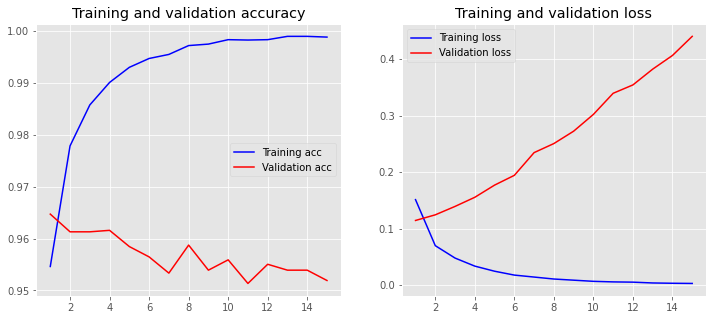

In [26]:
# Plot the learning curve
loss, accuracy = model.evaluate(cv_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(cv_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

The model is overfitting as can be seen on increasing validation loss. The accuracy plot also shows an overfitting model. To reduce the overfitting, an early stopping mechanism is introduced.

In [18]:
# With early stopping
# define the model: 1 layer neural network
reset_seed()
clear_session()
input_dim = cv_train.shape[1]

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# train the model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(cv_train, y_train, 
                         epochs=15,
                         verbose=False,
                         validation_data=(cv_test, y_test),
                         batch_size=5,
                         callbacks=[callback]
                        )

Training Accuracy: 0.9817
Testing Accuracy:  0.9639


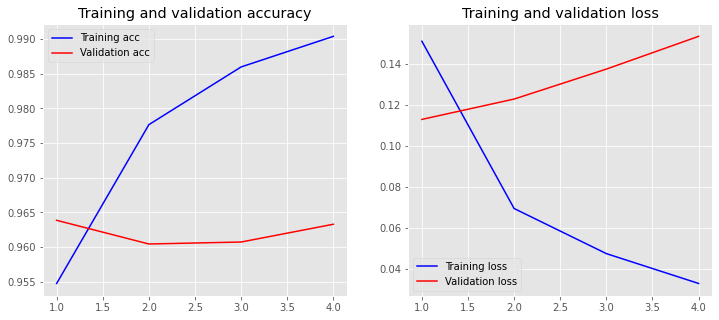

In [22]:
# Plot the learning curve
loss, accuracy = model.evaluate(cv_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(cv_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [23]:
# Predict
y_nn_predict = model.predict(cv_test)
y_nn_predict = [1 if x >= 0.5 else 0 for x in y_nn_predict]

# Print classification report
report = classification_report(y_test, y_nn_predict, target_names=['0','1'])
print('Neural Network Classification Report:')
print(report)

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       333
           1       0.97      0.99      0.98      3182

    accuracy                           0.96      3515
   macro avg       0.92      0.86      0.89      3515
weighted avg       0.96      0.96      0.96      3515



With early stopping, the model performs at least on par or slightly better than the logistic regression with high precision and  recall for class 0.

## 4. Data Representation: Word Embedding <a class="anchor" id="word-embedding"></a>
[Back to top](#top)

### 4.1. Hardcoded Indexed Word Embedding <a class="anchor" id="indexed-embedding"></a>

In [10]:
# Hardcoded indexed word embedding
tokenizer = Tokenizer(num_words=5000) # take most common num_words words as vocabulary size
tokenizer.fit_on_texts(x_train)

indexed_word_embedding_train = tokenizer.texts_to_sequences(x_train)
indexed_word_embedding_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1 # plus 1 because index 0 is a reserved index

print(vocab_size)
print(x_train[0])
print(indexed_word_embedding_train[0])

10169
friendly helpful professional quick easy sign friendly service knowledgeable
[33, 4, 65, 44, 7, 68, 33, 5, 205]


In [11]:
# padding with zeroes to make the embedding length the same
maxlen = 100 # remove long sentences
indexed_word_embedding_train = pad_sequences(indexed_word_embedding_train, padding='post', maxlen=maxlen)
indexed_word_embedding_test = pad_sequences(indexed_word_embedding_test, padding='post', maxlen=maxlen)

print(indexed_word_embedding_train[0, :])

[ 33   4  65  44   7  68  33   5 205   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [20]:
# train with embedding as part of the model structure using neural network architecture
reset_seed()
clear_session()
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten()) # converting matrix to single array (remove all dimensions except one)
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           508450    
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 558,471
Trainable params: 558,471
Non-trainable params: 0
_________________________________________________________________


In [21]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(indexed_word_embedding_train, y_train,
                        epochs=15,
                        verbose=False,
                        validation_data=(indexed_word_embedding_test, y_test),
                        batch_size=10,
                        callbacks=[callback]
                        )

Training Accuracy: 0.9841
Testing Accuracy:  0.9630


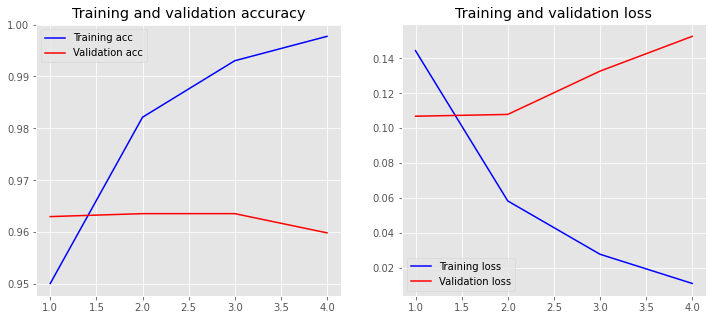

In [12]:
# Plot the learning curve
loss, accuracy = model.evaluate(indexed_word_embedding_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(indexed_word_embedding_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [13]:
# Predict
y_indexed_word_embedding_predict = model.predict(indexed_word_embedding_test)
y_indexed_word_embedding_predict = [1 if x >= 0.5 else 0 for x in y_indexed_word_embedding_predict]

# Print classification report
report = classification_report(y_test, y_indexed_word_embedding_predict, target_names=['0','1'])
print('Indexed Word Embedding Without Pooling Classification Report:')
print(report)

Indexed Word Embedding Without Pooling Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       333
           1       0.97      0.99      0.98      3182

    accuracy                           0.96      3515
   macro avg       0.91      0.87      0.89      3515
weighted avg       0.96      0.96      0.96      3515



Using the hardcoded indexes word embedding with only positional information, the model has lower precision, albeit slightly higher recall on class 0. As text data are sequential, it is better to have a model that is able to learn the sequence information rather than only learn each word position. To do this, a pooling layer is used, which will downsize the number of features. First, global max pooling layer is added, which will take the highest valued feature across all features.

In [31]:
# use pooling layer to improve feature learning
reset_seed()
clear_session()
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           508450    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 508,971
Trainable params: 508,971
Non-trainable params: 0
_________________________________________________________________


In [32]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(indexed_word_embedding_train, y_train,
                        epochs=15,
                        verbose=False,
                        validation_data=(indexed_word_embedding_test, y_test),
                        batch_size=10,
                        callbacks=[callback]
                        )

Training Accuracy: 0.9872
Testing Accuracy:  0.9684


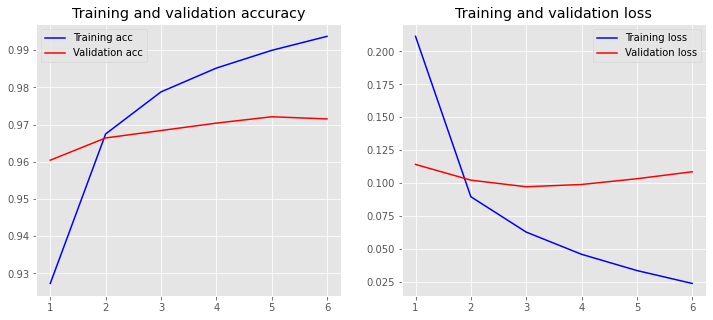

In [33]:
# Plot the learning curve
loss, accuracy = model.evaluate(indexed_word_embedding_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(indexed_word_embedding_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [34]:
# Predict
y_indexed_word_embedding_predict = model.predict(indexed_word_embedding_test)
y_indexed_word_embedding_predict = [1 if x >= 0.5 else 0 for x in y_indexed_word_embedding_predict]

# Print classification report
report = classification_report(y_test, y_indexed_word_embedding_predict, target_names=['0','1'])
print('Indexed Word Embedding With Global Max Pooling Classification Report:')
print(report)

Indexed Word Embedding With Global Max Pooling Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.83       333
           1       0.98      0.99      0.98      3182

    accuracy                           0.97      3515
   macro avg       0.92      0.89      0.90      3515
weighted avg       0.97      0.97      0.97      3515



The model shows improvements compared to the model without pooling layer. Next is the max pooling layer, which will take the highest valued feature for every pool sized features.

In [35]:
# use pooling layer to improve feature learning
reset_seed()
clear_session()
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           508450    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                25010     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 533,471
Trainable params: 533,471
Non-trainable params: 0
_________________________________________________________________


In [36]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(indexed_word_embedding_train, y_train,
                        epochs=15,
                        verbose=False,
                        validation_data=(indexed_word_embedding_test, y_test),
                        batch_size=10,
                        callbacks=[callback]
                        )

Training Accuracy: 0.9841
Testing Accuracy:  0.9667


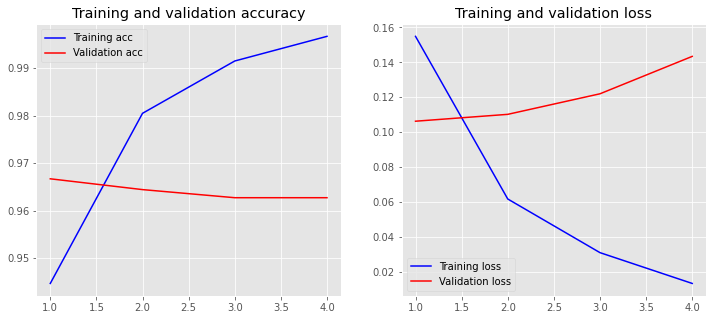

In [37]:
# Plot the learning curve
loss, accuracy = model.evaluate(indexed_word_embedding_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(indexed_word_embedding_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [38]:
# Predict
y_indexed_word_embedding_predict = model.predict(indexed_word_embedding_test)
y_indexed_word_embedding_predict = [1 if x >= 0.5 else 0 for x in y_indexed_word_embedding_predict]

# Print classification report
report = classification_report(y_test, y_indexed_word_embedding_predict, target_names=['0','1'])
print('Indexed Word Embedding With Max Pooling Classification Report:')
print(report)

Indexed Word Embedding With Max Pooling Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       333
           1       0.98      0.99      0.98      3182

    accuracy                           0.97      3515
   macro avg       0.92      0.88      0.90      3515
weighted avg       0.97      0.97      0.97      3515



This model is very similar to the model with global max pooling and better than the model without pooling layer.

### 4.2. Pretrained Word Embedding: GloVe (without training) <a class="anchor" id="glove-without"></a>
[Back to top](#top)

In [39]:
# load the embedding file, and assign the embedding vectors only to words available in the vocabulary
def create_glove_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # plus 1 because index 0 is a reserved index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [40]:
# Create the embedding matrix based on the current vocabulary in tokenizer.word_index
embedding_dim = 50

embedding_matrix = create_glove_embedding_matrix(
    '../Dataset/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

In [41]:
# Check the ratio of the vocabulary available in the embedding file
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8512144753663093

This means the GloVe embedding model covers 85% of the vocabulary in the dataset.

In [42]:
reset_seed()
clear_session()
embedding_dim = 50
maxlen = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           weights=[embedding_matrix], # each word has the embedding's predefined weight vector
                           input_length=maxlen, 
                           trainable=False)) # the dataset is not used as a part of embedding layer training
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           508450    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 508,971
Trainable params: 521
Non-trainable params: 508,450
_________________________________________________________________


In [43]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(indexed_word_embedding_train, y_train,
                        epochs=100,
                        verbose=False,
                        validation_data=(indexed_word_embedding_test, y_test),
                        batch_size=10,
                        callbacks=[callback])

Training Accuracy: 0.9259
Testing Accuracy:  0.9334


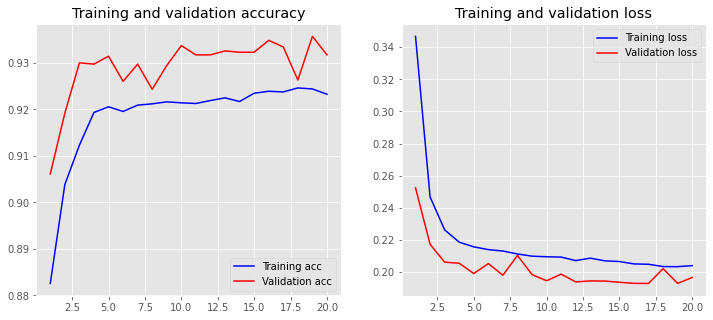

In [44]:
# Plot the learning curve
loss, accuracy = model.evaluate(indexed_word_embedding_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(indexed_word_embedding_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [45]:
# Predict
y_indexed_word_embedding_predict = model.predict(indexed_word_embedding_test)
y_indexed_word_embedding_predict = [1 if x >= 0.5 else 0 for x in y_indexed_word_embedding_predict]

# Print classification report
report = classification_report(y_test, y_indexed_word_embedding_predict, target_names=['0','1'])
print('GloVe Word Embedding Without Training Classification Report:')
print(report)

GloVe Word Embedding Without Training Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.38      0.52       333
           1       0.94      0.99      0.96      3182

    accuracy                           0.93      3515
   macro avg       0.88      0.69      0.74      3515
weighted avg       0.93      0.93      0.92      3515



Very poor performance in terms of spotting all class 0 (very low recall: more false negatives). This might be expected as the embedding model is not trained with the dataset vocabulary. The learning curves show that the validation accuracy is higher and validation loss is lower. This might be because of the unintentional 15% dropout on the vocabulary as the GloVe embedding model only recognises 85% of the dataset vocabulary. In this case, the training set becomes more difficult for the model to learn (thus, lower accuracy), but it is easier for the validation set as all vocabularies are present (as the 15% vocabularies now have the weights of the embedding from backpropagation).

### 4.3. Pretrained Word Embedding: GloVe (with training) <a class="anchor" id="glove-with"></a>
[Back to top](#top)

In [48]:
reset_seed()
clear_session()
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           508450    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 508,971
Trainable params: 508,971
Non-trainable params: 0
_________________________________________________________________


In [49]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(indexed_word_embedding_train, y_train,
                        epochs=100,
                        verbose=False,
                        validation_data=(indexed_word_embedding_test, y_test),
                        batch_size=10,
                        callbacks=[callback])

Training Accuracy: 0.9860
Testing Accuracy:  0.9656


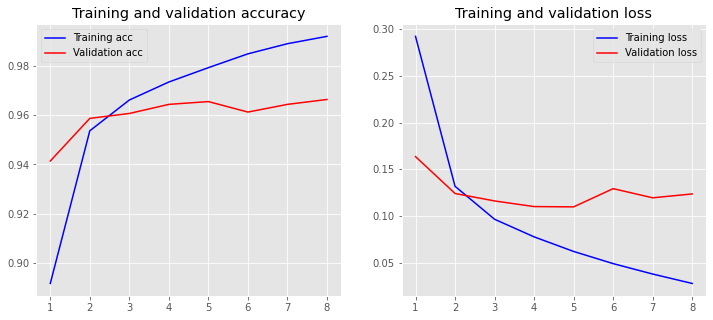

In [50]:
# Plot the learning curve
loss, accuracy = model.evaluate(indexed_word_embedding_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(indexed_word_embedding_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [51]:
# Predict
y_indexed_word_embedding_predict = model.predict(indexed_word_embedding_test)
y_indexed_word_embedding_predict = [1 if x >= 0.5 else 0 for x in y_indexed_word_embedding_predict]

# Print classification report
report = classification_report(y_test, y_indexed_word_embedding_predict, target_names=['0','1'])
print('GloVe Word Embedding With Training Classification Report:')
print(report)

GloVe Word Embedding With Training Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       333
           1       0.97      0.99      0.98      3182

    accuracy                           0.97      3515
   macro avg       0.92      0.87      0.89      3515
weighted avg       0.96      0.97      0.96      3515



Indeed, with the dataset being trained together within the embedding model, the performance improves alot. The model is on par, if not better, with the baseline models. The learning curves show more 'normal' behaviour because although there are 15% vocabularies dropout, they are trained together in the embedding layer.

### 4.4. Pretrained Word Embedding: Word2Vec (without training) <a class="anchor" id="word2vec-without"></a>
[Back to top](#top)

In [49]:
# ONLY NEED TO RUN ONCE: convert the binary file to text file
# load the word2vec pretrained model
model = KeyedVectors.load_word2vec_format('../Dataset/GoogleNews-vectors-negative300.bin', binary=True)

# save model in ASCII (word2vec) format
model.wv.save_word2vec_format('../Dataset/embedding_word2vec.txt', binary=False)

In [54]:
# load the embedding file, and assign the embedding vectors only to words available in the vocabulary
def create_word2vec_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # plus 1 because index 0 is a reserved index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [55]:
# Create the embedding matrix based on the current vocabulary in tokenizer.word_index
embedding_dim = 50

embedding_matrix = create_word2vec_embedding_matrix(
    '../Dataset/embedding_word2vec.txt',
    tokenizer.word_index, embedding_dim)

In [56]:
# Check the ratio of the vocabulary available in the embedding file
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8314485200118006

In [57]:
reset_seed()
clear_session()
embedding_dim = 50
maxlen = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           weights=[embedding_matrix], # each word has the embedding's predefined weight vector
                           input_length=maxlen, 
                           trainable=False)) # the dataset is not used as a part of embedding layer training
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           508450    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 508,971
Trainable params: 521
Non-trainable params: 508,450
_________________________________________________________________


In [58]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(indexed_word_embedding_train, y_train,
                        epochs=100,
                        verbose=False,
                        validation_data=(indexed_word_embedding_test, y_test),
                        batch_size=10,
                        callbacks=[callback])

Training Accuracy: 0.9177
Testing Accuracy:  0.9226


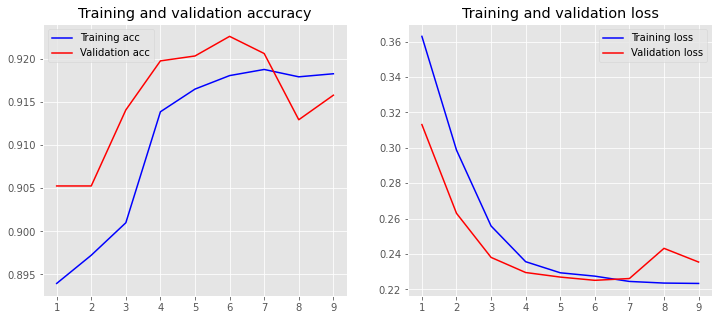

In [59]:
# Plot the learning curve
loss, accuracy = model.evaluate(indexed_word_embedding_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(indexed_word_embedding_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [60]:
# Predict
y_indexed_word_embedding_predict = model.predict(indexed_word_embedding_test)
y_indexed_word_embedding_predict = [1 if x >= 0.5 else 0 for x in y_indexed_word_embedding_predict]

# Print classification report
report = classification_report(y_test, y_indexed_word_embedding_predict, target_names=['0','1'])
print('Word2Vec Without Training Classification Report:')
print(report)

Word2Vec Without Training Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.26      0.39       333
           1       0.93      0.99      0.96      3182

    accuracy                           0.92      3515
   macro avg       0.85      0.63      0.67      3515
weighted avg       0.91      0.92      0.90      3515



Similar to the GloVe model without training, the model performs poorly and the learning curves show 'abnormal' behaviour that might be caused by the 17% vocabularies dropout in the word2vec model.

### 4.5. Pretrained Word Embedding: Word2Vec (with training) <a class="anchor" id="word2vec-with"></a>
[Back to top](#top)

In [61]:
reset_seed()
clear_session()
embedding_dim = 50
maxlen = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           weights=[embedding_matrix], # each word has the embedding's predefined weight vector
                           input_length=maxlen, 
                           trainable=True)) # the dataset is not used as a part of embedding layer training
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           508450    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 508,971
Trainable params: 508,971
Non-trainable params: 0
_________________________________________________________________


In [62]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(indexed_word_embedding_train, y_train,
                        epochs=100,
                        verbose=False,
                        validation_data=(indexed_word_embedding_test, y_test),
                        batch_size=10,
                        callbacks=[callback])

Training Accuracy: 0.9937
Testing Accuracy:  0.9696


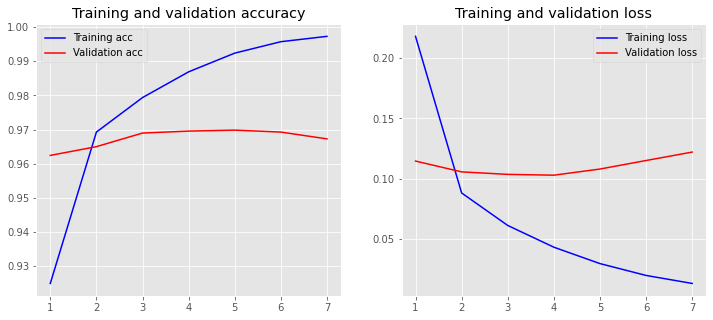

In [63]:
# Plot the learning curve
loss, accuracy = model.evaluate(indexed_word_embedding_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(indexed_word_embedding_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [64]:
# Predict
y_indexed_word_embedding_predict = model.predict(indexed_word_embedding_test)
y_indexed_word_embedding_predict = [1 if x >= 0.5 else 0 for x in y_indexed_word_embedding_predict]

# Print classification report
report = classification_report(y_test, y_indexed_word_embedding_predict, target_names=['0','1'])
print('Word2Vec With Training Classification Report:')
print(report)

Word2Vec With Training Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       333
           1       0.98      0.99      0.98      3182

    accuracy                           0.97      3515
   macro avg       0.93      0.89      0.91      3515
weighted avg       0.97      0.97      0.97      3515



The model works well and comparable with the GloVe embedding model and other baseline models. The model can detect more class 0 although with a slightly lower precision.

## 5. Convolutional Neural Network <a class="anchor" id="cnn"></a>
[Back to top](#top)

### 5.1. CNN without pretrained embedding <a class="anchor" id="cnn-without-pretrained"></a>

In [65]:
reset_seed()
clear_session()
embedding_dim = 50
maxlen = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           508450    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541,879
Trainable params: 541,879
Non-trainable params: 0
_________________________________________________________________


In [66]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(indexed_word_embedding_train, y_train,
                        epochs=50,
                        verbose=False,
                        validation_data=(indexed_word_embedding_test, y_test),
                        batch_size=10,
                        callbacks=[callback])

Training Accuracy: 0.9922
Testing Accuracy:  0.9639


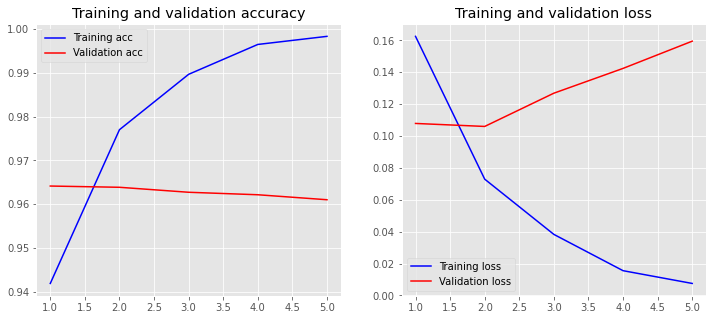

In [67]:
# Plot the learning curve
loss, accuracy = model.evaluate(indexed_word_embedding_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(indexed_word_embedding_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [68]:
# Predict
y_indexed_word_embedding_predict = model.predict(indexed_word_embedding_test)
y_indexed_word_embedding_predict = [1 if x >= 0.5 else 0 for x in y_indexed_word_embedding_predict]

# Print classification report
report = classification_report(y_test, y_indexed_word_embedding_predict, target_names=['0','1'])
print('CNN Classification Report:')
print(report)

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       333
           1       0.98      0.98      0.98      3182

    accuracy                           0.96      3515
   macro avg       0.90      0.88      0.89      3515
weighted avg       0.96      0.96      0.96      3515



A decent model that is comparable with the baseline models. It has a slightly lower precision than the neural network model, but higher recall.

### 5.2. CNN with GloVe embedding <a class="anchor" id="cnn-with-glove"></a>
[Back to top](#top)

In [12]:
# load the embedding file, and assign the embedding vectors only to words available in the vocabulary
def create_glove_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # plus 1 because index 0 is a reserved index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [14]:
# Create the embedding matrix based on the current vocabulary in tokenizer.word_index
embedding_dim = 50

embedding_matrix = create_glove_embedding_matrix(
    '../Dataset/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

In [71]:
reset_seed()
clear_session()
embedding_dim = 50
maxlen = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           weights=[embedding_matrix], # each word has the embedding's predefined weight vector
                           input_length=maxlen, 
                           trainable=True)) # the dataset is used as a part of embedding layer training
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           508450    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541,879
Trainable params: 541,879
Non-trainable params: 0
_________________________________________________________________


In [72]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(indexed_word_embedding_train, y_train,
                        epochs=50,
                        verbose=False,
                        validation_data=(indexed_word_embedding_test, y_test),
                        batch_size=10,
                        callbacks=[callback])

Training Accuracy: 0.9925
Testing Accuracy:  0.9661


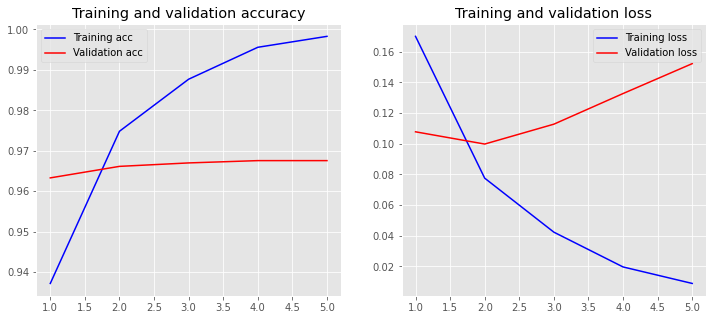

In [73]:
# Plot the learning curve
loss, accuracy = model.evaluate(indexed_word_embedding_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(indexed_word_embedding_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [74]:
# Predict
y_indexed_word_embedding_predict = model.predict(indexed_word_embedding_test)
y_indexed_word_embedding_predict = [1 if x >= 0.5 else 0 for x in y_indexed_word_embedding_predict]

# Print classification report
report = classification_report(y_test, y_indexed_word_embedding_predict, target_names=['0','1'])
print('CNN with GloVe Word Embedding Classification Report:')
print(report)

CNN with GloVe Word Embedding Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.80       333
           1       0.97      0.99      0.98      3182

    accuracy                           0.97      3515
   macro avg       0.93      0.86      0.89      3515
weighted avg       0.96      0.97      0.96      3515



With GloVe embedding, it is arguably better than the model without pretrained embedding, and performs as well as other baseline models. Compared with the neural network with GloVe embedding, this model has a higher recall with a comparatively still good precision, which is an advantage as the model recognises more class 0 data.

### 5.3. CNN with Word2Vec embedding <a class="anchor" id="cnn-with-word2vec"></a>
[Back to top](#top)

In [75]:
# load the embedding file, and assign the embedding vectors only to words available in the vocabulary
def create_word2vec_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # plus 1 because index 0 is a reserved index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [76]:
# Create the embedding matrix based on the current vocabulary in tokenizer.word_index
embedding_dim = 50

embedding_matrix = create_word2vec_embedding_matrix(
    '../Dataset/embedding_word2vec.txt',
    tokenizer.word_index, embedding_dim)

In [77]:
reset_seed()
clear_session()
embedding_dim = 50
maxlen = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           weights=[embedding_matrix], # each word has the embedding's predefined weight vector
                           input_length=maxlen, 
                           trainable=True)) # the dataset is used as a part of embedding layer training
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           508450    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541,879
Trainable params: 541,879
Non-trainable params: 0
_________________________________________________________________


In [78]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(indexed_word_embedding_train, y_train,
                        epochs=50,
                        verbose=False,
                        validation_data=(indexed_word_embedding_test, y_test),
                        batch_size=10,
                        callbacks=[callback])

Training Accuracy: 0.9942
Testing Accuracy:  0.9687


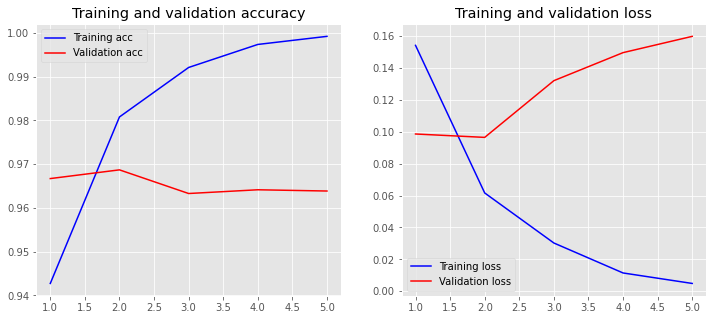

In [79]:
# Plot the learning curve
loss, accuracy = model.evaluate(indexed_word_embedding_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(indexed_word_embedding_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [80]:
# Predict
y_indexed_word_embedding_predict = model.predict(indexed_word_embedding_test)
y_indexed_word_embedding_predict = [1 if x >= 0.5 else 0 for x in y_indexed_word_embedding_predict]

# Print classification report
report = classification_report(y_test, y_indexed_word_embedding_predict, target_names=['0','1'])
print('CNN with Word2Vec Classification Report:')
print(report)

CNN with Word2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.78      0.83       333
           1       0.98      0.99      0.98      3182

    accuracy                           0.97      3515
   macro avg       0.93      0.89      0.90      3515
weighted avg       0.97      0.97      0.97      3515



With Word2vec embedding, it is much better than the model without pretrained embedding as it retains the recall score, but with higher precision.

### 5.4. Hyperparameter Tuning <a class="anchor" id="cnn-hyperparameter-tuning"></a>
[Back to top](#top)

Based on the experiment, the CNN with Word2vec embedding model is quite good to be used as the production model. Then, parameter tuning the model to find the best combination of parameters and see if it can improve the performance.

In [81]:
# Define a function that return a Keras model
def create_model(num_filters, kernel_size, embedding_dim, maxlen):
    # Hardcoded indexed word embedding
    tokenizer = Tokenizer(num_words=5000) # take most common num_words words as vocabulary size
    tokenizer.fit_on_texts(x_train)

    word_index = tokenizer.word_index
    
    # Create the embedding matrix based on the current vocabulary in tokenizer.word_index
    vocab_size = len(word_index) + 1

    embedding_matrix = create_word2vec_embedding_matrix(
        '../Dataset/embedding_word2vec.txt',
        word_index, embedding_dim)
    
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, # Size of the vocabulary, i.e. maximum integer index + 1
                           output_dim=embedding_dim, # Dimension of the dense embedding
                           weights=[embedding_matrix], # each word has the initial embedding's predefined weight vector
                           input_length=maxlen, # Length of input sequences, when it is constant
                           trainable=True)) # the dataset is used as a part of embedding layer training
    model.add(layers.Conv1D(num_filters, 
                            kernel_size, 
                            activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [82]:
# setting the parameter dictionary
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  embedding_dim=[50],
                  maxlen=[100])

In [83]:
# Initiate the model, run hyperparameter tuning
reset_seed()
model = KerasClassifier(build_fn=create_model, #construct, compile and return a model, which will then be used to fit/predict
                        epochs=20, 
                        batch_size=10,
                        verbose=False
                       )

search_res = RandomizedSearchCV(estimator=model, 
                                param_distributions=param_grid,
                                cv=5, # cross validate the training set to cover more examples
                                verbose=1, 
                                n_iter=5, # number of parameter settings that are sampled
                                random_state=1
                               )

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model_result = search_res.fit(indexed_word_embedding_train, y_train, callbacks=[callback])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 182.4min finished


In [85]:
# Evaluate testing set
test_accuracy = search_res.score(indexed_word_embedding_test, y_test)

output_file = 'output.txt'
with open(output_file, 'a') as f:
    s = ('Running dataset \nBest Accuracy : '
         '{:.4f} \n{} \nTest Accuracy : {:.4f}')
    output_string = s.format(
        model_result.best_score_,
        model_result.best_params_,
        test_accuracy)
    print(output_string)
    f.write(output_string)

Running dataset 
Best Accuracy : 0.9587 
{'num_filters': 32, 'maxlen': 100, 'kernel_size': 7, 'embedding_dim': 50} 
Test Accuracy : 0.9610




Now that the best combination of parameters has been found, train a new model with this set of parameters.

In [15]:
reset_seed()
clear_session()
embedding_dim = 50
maxlen = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                          output_dim=embedding_dim, 
                          weights=[embedding_matrix], # each word has the embedding's predefined weight vector
                          input_length=maxlen, 
                          trainable=True)) # the dataset is used as a part of embedding layer training
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           508450    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 94, 32)            11232     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 520,023
Trainable params: 520,023
Non-trainable params: 0
_________________________________________________________________


In [16]:
callback = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
training_log = model.fit(indexed_word_embedding_train, y_train,
                        epochs=50,
                        verbose=False,
                        validation_data=(indexed_word_embedding_test, y_test),
                        batch_size=10,
                        callbacks=[callback])

Training Accuracy: 0.9910
Testing Accuracy:  0.9639


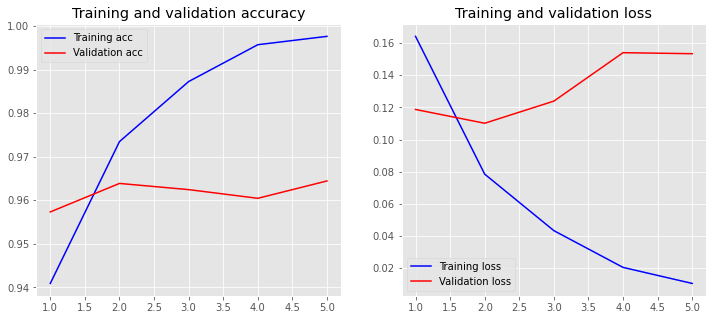

In [17]:
# Plot the learning curve
loss, accuracy = model.evaluate(indexed_word_embedding_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(indexed_word_embedding_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_training_log(training_log)

In [18]:
# Predict
y_indexed_word_embedding_predict = model.predict(indexed_word_embedding_test)
y_indexed_word_embedding_predict = [1 if x >= 0.5 else 0 for x in y_indexed_word_embedding_predict]

# Print classification report
report = classification_report(y_test, y_indexed_word_embedding_predict, target_names=['0','1'])
print('Best Parameters CNN With Word2Vec Embedding Classification Report:')
print(report)

Best Parameters CNN With Word2Vec Embedding Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       333
           1       0.98      0.98      0.98      3182

    accuracy                           0.96      3515
   macro avg       0.90      0.88      0.89      3515
weighted avg       0.96      0.96      0.96      3515



In [19]:
df_lr = pd.DataFrame()
df_lr['x_test'] = x_test
df_lr['y_test'] = y_test
df_lr['y_predict'] = y_indexed_word_embedding_predict

tp = len(df_lr[(df_lr['y_test'] == 0) & (df_lr['y_test'] == df_lr['y_predict'])])
fn = len(df_lr[(df_lr['y_test'] == 0) & (df_lr['y_test'] != df_lr['y_predict'])])
fp = len(df_lr[(df_lr['y_test'] == 1) & (df_lr['y_test'] != df_lr['y_predict'])])
print(tp, fn, fp)

262 71 56


In [20]:
model.save('../Model/CNN_word2vec_biased.h5')

Make all predictions:

In [10]:
model = keras.models.load_model('../Model/CNN_word2vec_biased.h5')

In [11]:
df_all = pd.read_csv('../Dataset/trustpilot_reviews.csv')

In [12]:
# Hardcoded indexed word embedding
tokenizer = Tokenizer(num_words=5000) # take most common num_words words as vocabulary size
tokenizer.fit_on_texts(x_train)

indexed_word_embedding_all = tokenizer.texts_to_sequences(df['lemmatized_feedback'])

vocab_size = len(tokenizer.word_index) + 1 # plus 1 because index 0 is a reserved index

print(vocab_size)
print(x_train[1])
print(indexed_word_embedding_all[1])

10169
helpful conversation helpful conversation professional reassure calm compassionate lauren credit organisation
[74, 40, 244, 30, 276, 27, 74, 40, 244, 239, 312, 253, 17, 3135, 2, 178, 77, 4157, 1373, 207, 27, 82, 1932, 2005, 54, 19, 202, 17, 228, 4942, 3, 135, 82, 127, 34, 59, 18, 27, 225, 1010]


In [13]:
# padding with zeroes to make the embedding length the same
maxlen = 100 # remove long sentences
indexed_word_embedding_all = pad_sequences(indexed_word_embedding_all, padding='post', maxlen=maxlen)

print(indexed_word_embedding_all[1, :])

[  74   40  244   30  276   27   74   40  244  239  312  253   17 3135
    2  178   77 4157 1373  207   27   82 1932 2005   54   19  202   17
  228 4942    3  135   82  127   34   59   18   27  225 1010    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [14]:
prediction_score = model.predict(indexed_word_embedding_all)
prediction = [1 if x >= 0.5 else 0 for x in prediction_score]

In [15]:
df_all['prediction_score'] = prediction_score
df_all['predicted'] = prediction

In [16]:
df_all.to_csv('../Dataset/trustpilot_reviews_imbalanced_prediction.csv', index=False)